# Contexto y motivación:
Chile enfrenta una crisis demográfica impulsada por una disminución histórica y sostenida en la tasa de fecundidad total (TFT), siendo este fenómeno la motivación central de nuestro proyecto.
La tasa de fecundidad total(TFT) se interpreta como el número promedio de hijos que una mujer tendría a lo largo de su vida fértil. La tendencia a la baja comenzó aproximadamente en 1963, la TFT ya se situaba en 4,54 hijos por mujer 62 años después en el 2023 el contraste es preocupante, la TFT alcanzó un valor de aproximadamente 1,2 hijos por mujer según datos del grupo banco mundial (datos.bancomundial.org). Este valor es alarmante considerando que el nivel requerido para el reemplazo generacional y poder mantener una población estable en la cual no haya migración es de aproximadamente 2.1 hijo por mujer, esta tasa indica que la generación actual está siendo reemplazada sólo en un 57% por la siguiente, consolidando a Chile como una de las naciones con la fecundidad más baja de América Latina. Esto nos lleva a dos grandes consecuencias; un envejecimiento poblacional acelerado y una reducción de la base de la población económica activa.
La urgencia de esta situación demográfica motiva la investigación siendo nuestro objetivo poder identificar y cuantificar la influencia de factores socioeconómicos y geográficos en la decisión de tener hijos. Este análisis profundo es viable gracias a la disponibilidad de un ecosistema de datos públicos:
-              Datos socioeconómicos: bases del ministerio de desarrollo social y familia (BIDAT) para variables de vulnerabilidad junto con la localidad,
-              Contexto demográfico fino: utilización de datos del censo los cuales permiten asociar las tasas de natalidad a nivel comunal con la estructura poblacional detallada como los niveles educativos.
-              Disponibilidad de datos de nacimientos en serie desde 1992 permitiendo realizar análisis de tendencia y series de tiempo.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error
import os

In [4]:
path_nac = "../Data/clean data/nacimientos/Serie_nacimientos_1992-2022.parquet"
path_censo2017 = '../Data/clean data/censo/2017/microdato2017.csv'
path_rsh_pob = "../Data/clean data/RSH/DATOS_CONSOLIDADOS_RSH_limpio.csv"

In [84]:
carpeta_graf = r'C:\Users\boris\Documents\GitHub\Trabajo-grupo-cs-de-datos\graficos'

In [36]:
df_nac = pd.read_parquet(path_nac)

In [40]:
df_nac

,Mes,Anio,Sexo,Rango_edad_M,Educacion_M,Rango_edad_P,Educacion_P,Region
0,1.0,1992,1,30 A 34,2,35 A 39,6.0,VALPARAISO
1,1.0,1992,1,30 A 34,4,40 A 44,1.0,NUBLE
2,1.0,1992,1,25 A 29,6,35 A 39,6.0,METROPOLITANA
3,1.0,1992,1,20 A 24,4,25 A 29,4.0,LA ARAUCANIA
5,1.0,1992,1,20 A 24,8,40 A 44,5.0,ARICA Y PARINACOTA
...,...,...,...,...,...,...,...,...
7445226,12.0,2022,2,45 A 49,8,45 A 49,8.0,MAULE
7445231,12.0,2022,2,35 A 39,3,20 A 24,4.0,BIOBIO
7445236,12.0,2022,2,20 A 24,8,30 A 34,2.0,METROPOLITANA
7445243,12.0,2022,2,35 A 39,2,35 A 39,8.0,MAULE


In [64]:
df_nac['Rango_edad_M'].unique()

array(['30 A 34', '25 A 29', '20 A 24', '35 A 39', '40 A 44', '15 A 19',
       '45 A 49', 'MENORES 15 AÑO', '50 O MAS', 'NO ESPECIFICADO'],
      dtype=object)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def transformar_rango_edad(rango):
    s = str(rango).upper().strip()
    
    if ' A ' in s:
        try:
            partes = s.split(' A ')
            min_edad = int(partes[0])
            max_edad = int(partes[1])
            return (min_edad + max_edad) / 2
        except:
            return np.nan

    if 'MENOR' in s:
        return 14
        
    if 'MAS' in s or 'MÁS' in s:
        return 52
    

    return np.nan


df_eda = df_nac.copy()

df_eda['Edad_M_Numerica'] = df_eda['Rango_edad_M'].apply(transformar_rango_edad)


df_eda['Edad_P_Numerica'] = df_eda['Rango_edad_P'].apply(transformar_rango_edad)

df_eda['Educacion_M'] = pd.to_numeric(df_eda['Educacion_M'], errors='coerce')
df_eda['Educacion_P'] = pd.to_numeric(df_eda['Educacion_P'], errors='coerce')

<Figure size 1200x800 with 0 Axes>

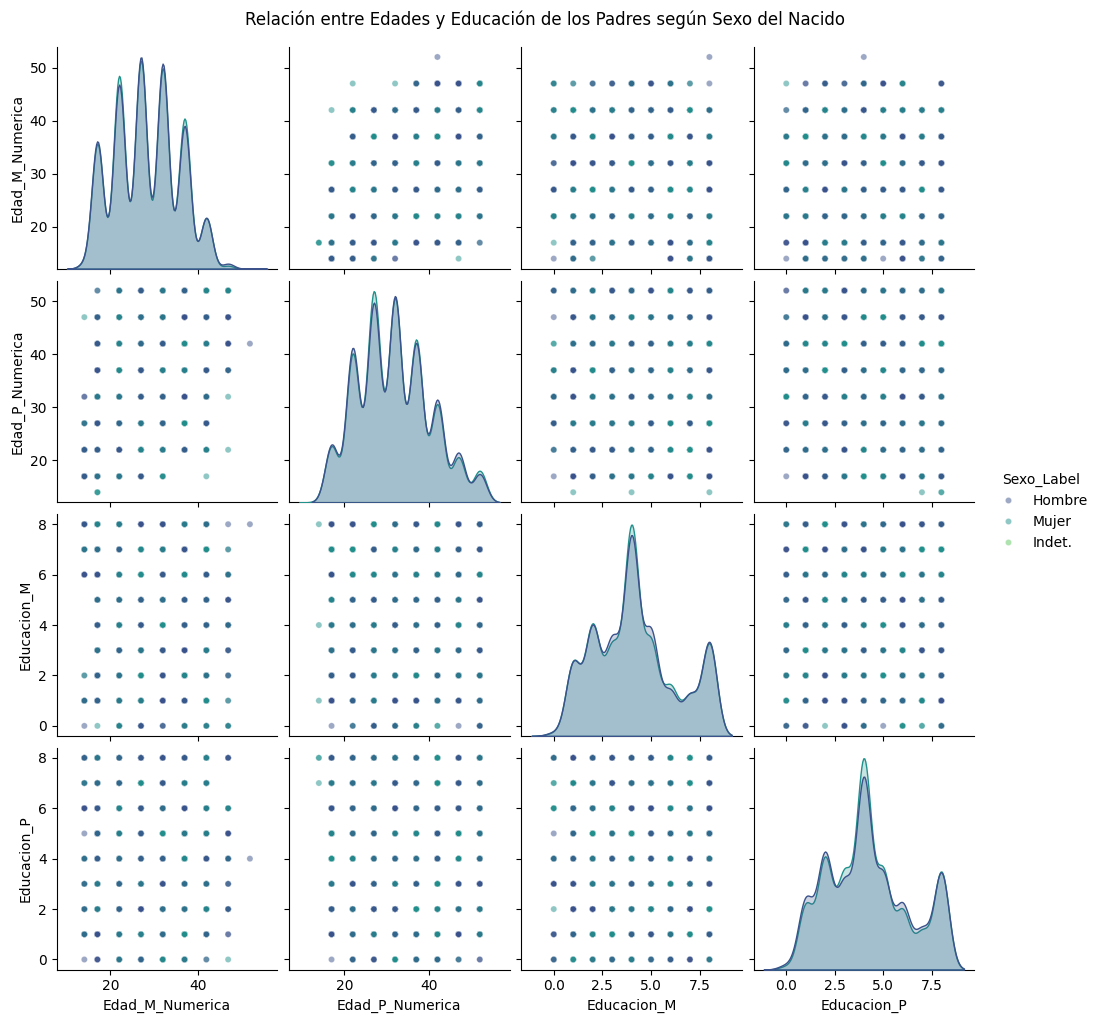

In [91]:
cols_interes = ['Sexo', 'Edad_M_Numerica', 'Edad_P_Numerica', 'Educacion_M', 'Educacion_P']
df_plot = df_eda[cols_interes].dropna()

df_sample = df_plot.sample(n=10000, random_state=42)

df_sample['Sexo_Label'] = df_sample['Sexo'].map({1: 'Hombre', 2: 'Mujer', 9: 'Indet.'})

plt.figure(figsize=(12, 8))
sns.pairplot(
    df_sample, 
    hue='Sexo_Label',
    vars=['Edad_M_Numerica', 'Edad_P_Numerica', 'Educacion_M', 'Educacion_P'], 
    palette='viridis',
    plot_kws={'alpha': 0.5, 's': 20})

plt.suptitle("Relación entre Edades y Educación de los Padres según Sexo del Nacido", y=1.02)
plt.savefig(os.path.join(carpeta_graf, 'Relacion edad-educacion.png'), dpi=300, bbox_inches='tight')
plt.show()

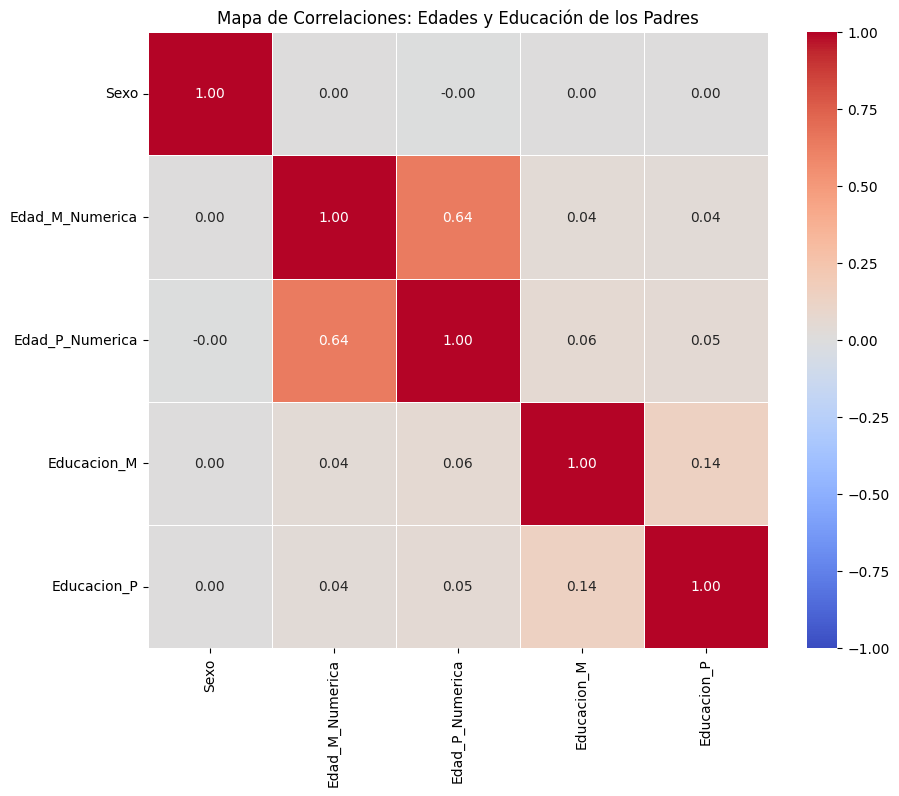

In [92]:
matriz_corr = df_eda[cols_interes].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",  
    linewidths=0.5, 
    vmin=-1, vmax=1,
    center=0          
)

plt.title("Mapa de Correlaciones: Edades y Educación de los Padres")
plt.savefig(os.path.join(carpeta_graf, 'Correlaciones edad-educacion.png'), dpi=300, bbox_inches='tight')
plt.show()

hay una relacion positiva entre las edades del padre y la madre

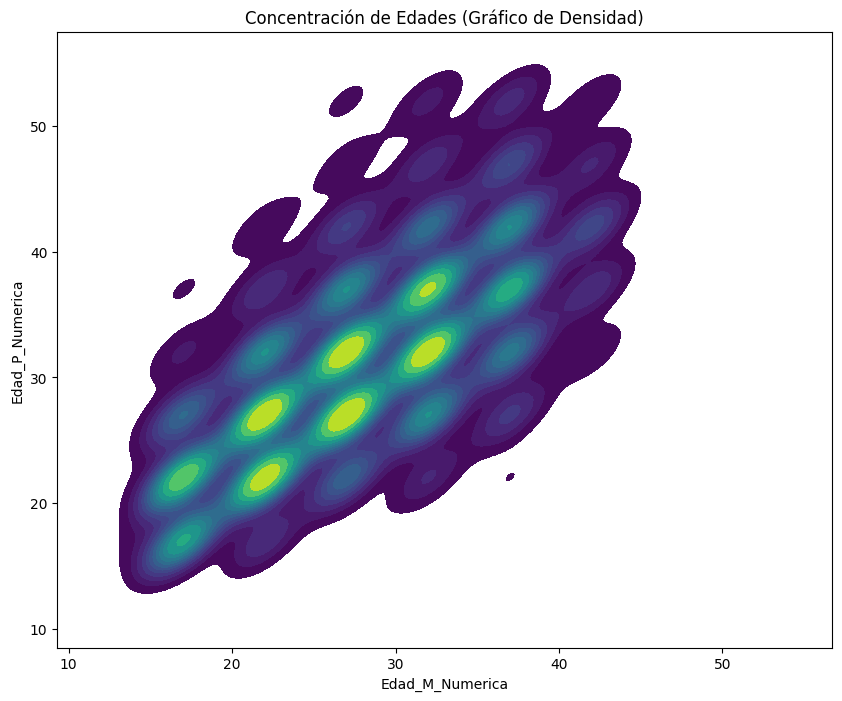

In [93]:
plt.figure(figsize=(10, 8))

sns.kdeplot(
    x='Edad_M_Numerica', 
    y='Edad_P_Numerica', 
    data=df_sample,
    cmap="viridis", 
    fill=True, 
    thresh=0.05, 
    levels=15 
)

plt.title('Concentración de Edades (Gráfico de Densidad)')
plt.savefig(os.path.join(carpeta_graf, 'concentracion de edades.png'), dpi=300, bbox_inches='tight')
plt.show()

Cual es la tendencia de los nacimientos en el tiempo?

In [67]:
df_nac['Mes'] = df_nac['Mes'].astype('Int64')
df_nac['Fecha'] = pd.to_datetime(df_nac["Anio"].astype(str) + '-' + df_nac['Mes'].astype(str))
nacimientos_por_mes = df_nac.groupby('Fecha').size().reset_index(name='Total_Nacimientos')
nacimientos_por_mes= nacimientos_por_mes.sort_values('Fecha')
nacimientos_por_mes

,Fecha,Total_Nacimientos
0,1992-01-01,10990
1,1992-02-01,10157
2,1992-03-01,10452
3,1992-04-01,10137
4,1992-05-01,10258
...,...,...
367,2022-08-01,5938
368,2022-09-01,6008
369,2022-10-01,5930
370,2022-11-01,5871


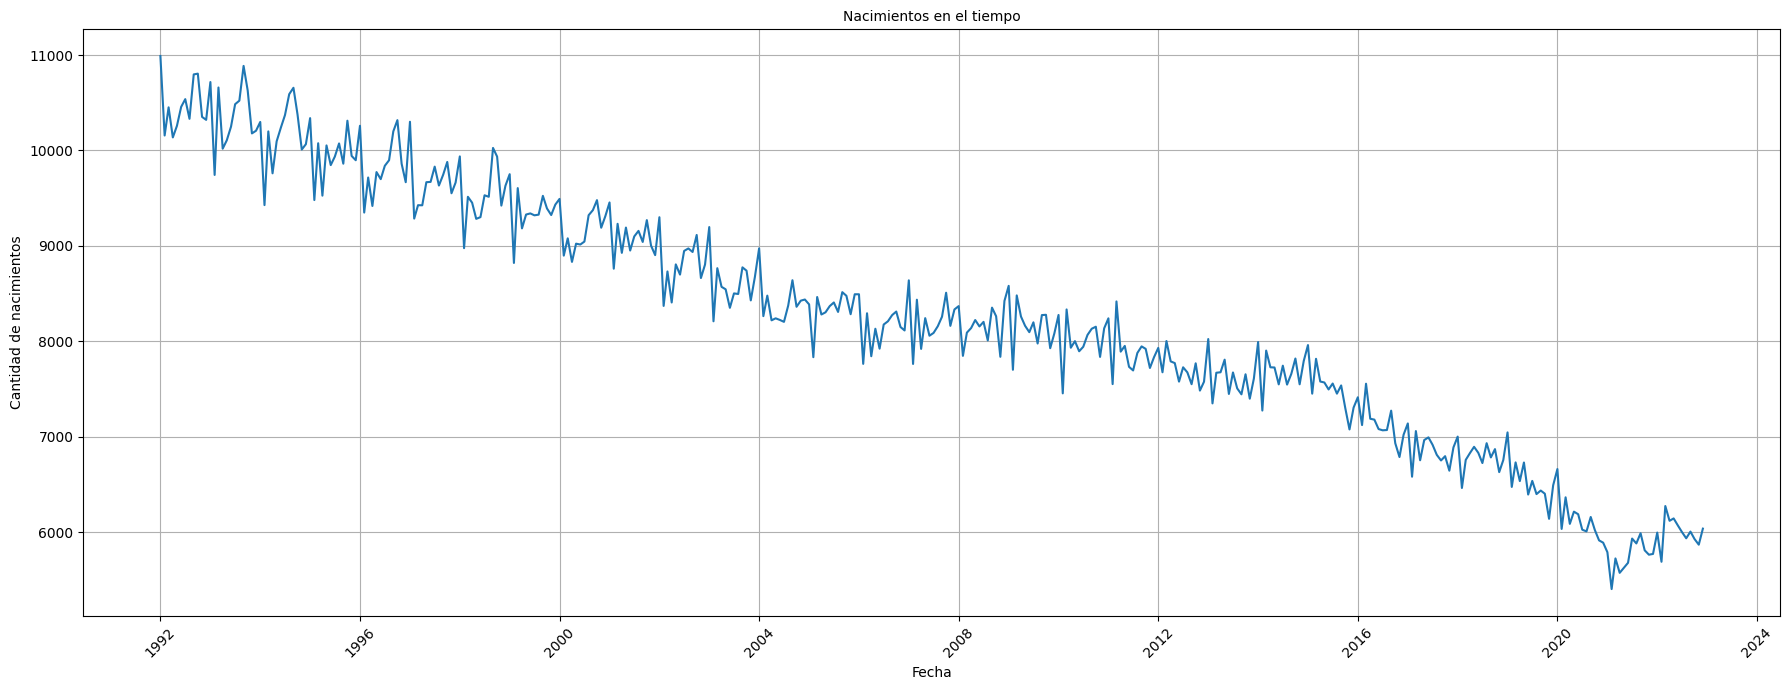

In [94]:
plt.figure(figsize=(18, 7))

plt.plot(
    nacimientos_por_mes['Fecha'],
    nacimientos_por_mes['Total_Nacimientos'],
    linestyle = '-'
)

plt.title('Nacimientos en el tiempo', fontsize = 10)
plt.xlabel("Fecha")
plt.ylabel('Cantidad de nacimientos')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(carpeta_graf, 'Nacimientos en el tiempo.png'), dpi=300, bbox_inches='tight')
plt.show()

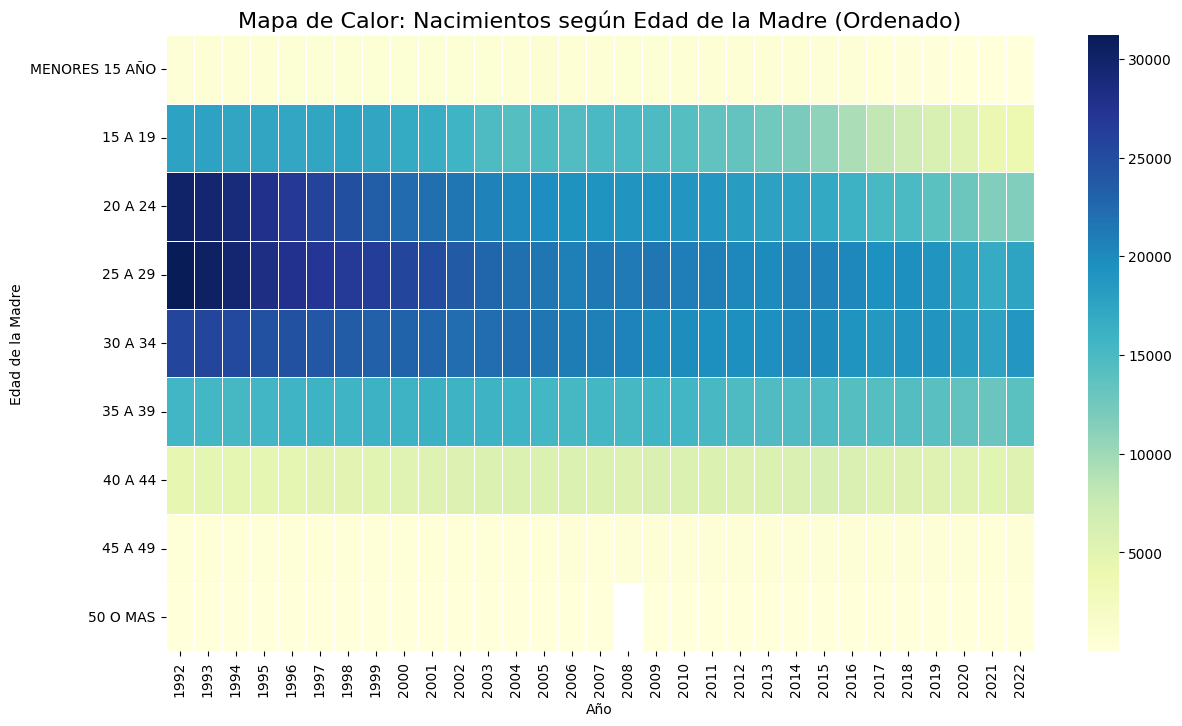

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_edad_madre = df_nac.groupby(['Anio', 'Rango_edad_M']).size().reset_index(name='Nacimientos')

heatmap_data = df_edad_madre.pivot(index='Rango_edad_M', columns='Anio', values='Nacimientos')

orden_logico = [
    'MENORES 15 AÑO',
    '15 A 19',
    '20 A 24',
    '25 A 29',
    '30 A 34',
    '35 A 39',
    '40 A 44',
    '45 A 49',
    '50 O MAS'
]

heatmap_data = heatmap_data.reindex(orden_logico)

plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data, 
    cmap='YlGnBu', 
    annot=False, 
    fmt="d", 
    linewidths=.5
)

plt.title('Mapa de Calor: Nacimientos según Edad de la Madre (Ordenado)', fontsize=16)
plt.ylabel('Edad de la Madre')
plt.xlabel('Año')
plt.savefig(os.path.join(carpeta_graf, 'Nacimientos segun edad madre.png'), dpi=300, bbox_inches='tight')
plt.show()

Notamos clara tendencia a la bajada, importante

C:\Users\boris\AppData\Local\Temp\ipykernel_9708\555641857.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


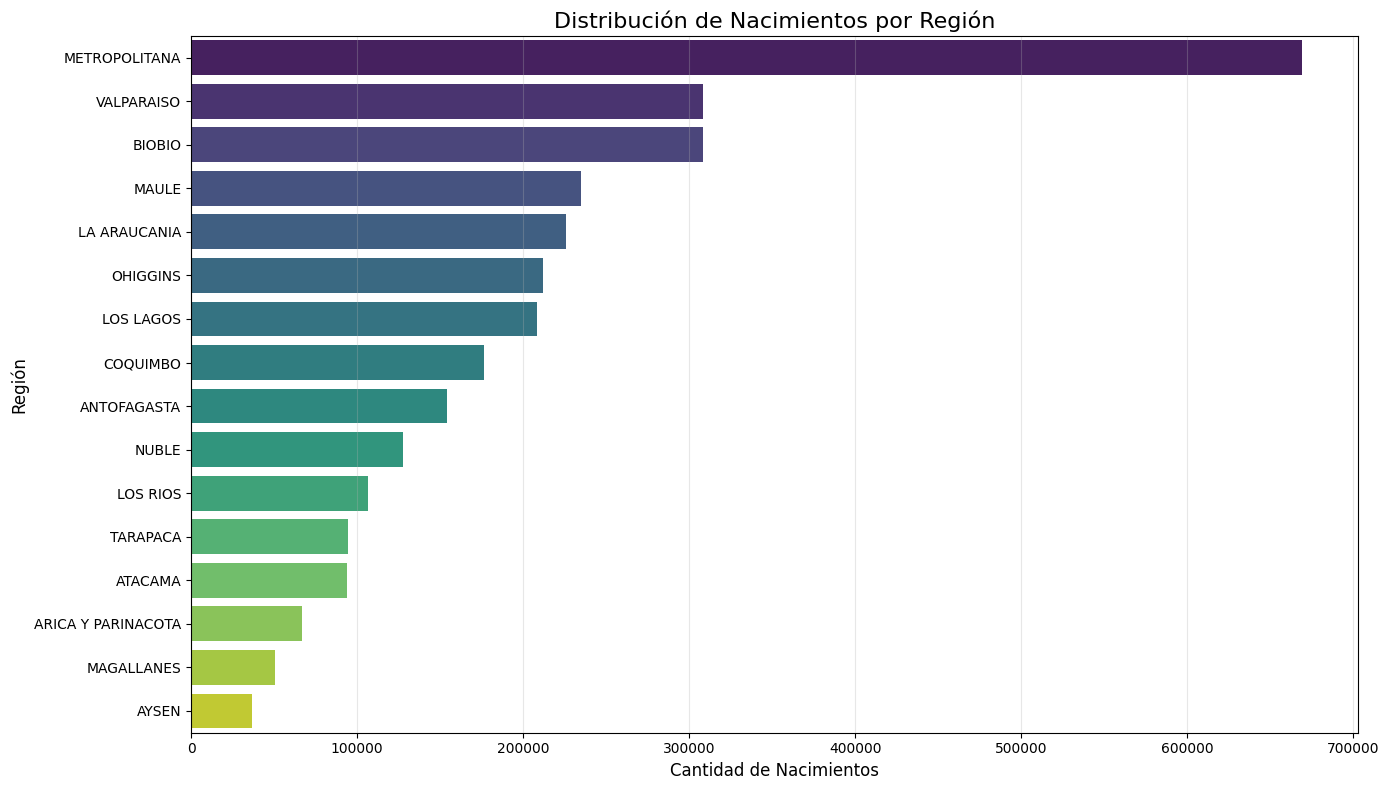

In [96]:
nacimientos_por_region = df_nac['Region'].value_counts().reset_index()
nacimientos_por_region.columns = ['Region', 'Total_Nacimientos']

plt.figure(figsize=(14, 8))
sns.barplot(
    data=nacimientos_por_region,
    x='Total_Nacimientos',
    y='Region',
    palette='viridis'
)
plt.title('Distribución de Nacimientos por Región', fontsize=16)
plt.xlabel('Cantidad de Nacimientos', fontsize=12)
plt.ylabel('Región', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(carpeta_graf, 'distribucion nacimientos segun region.png'), dpi=300, bbox_inches='tight')
plt.show()

In [47]:
nac_por_eduM = df_nac.groupby(['Anio', "Educacion_M"]).size().reset_index(name='Total_nacimientos')

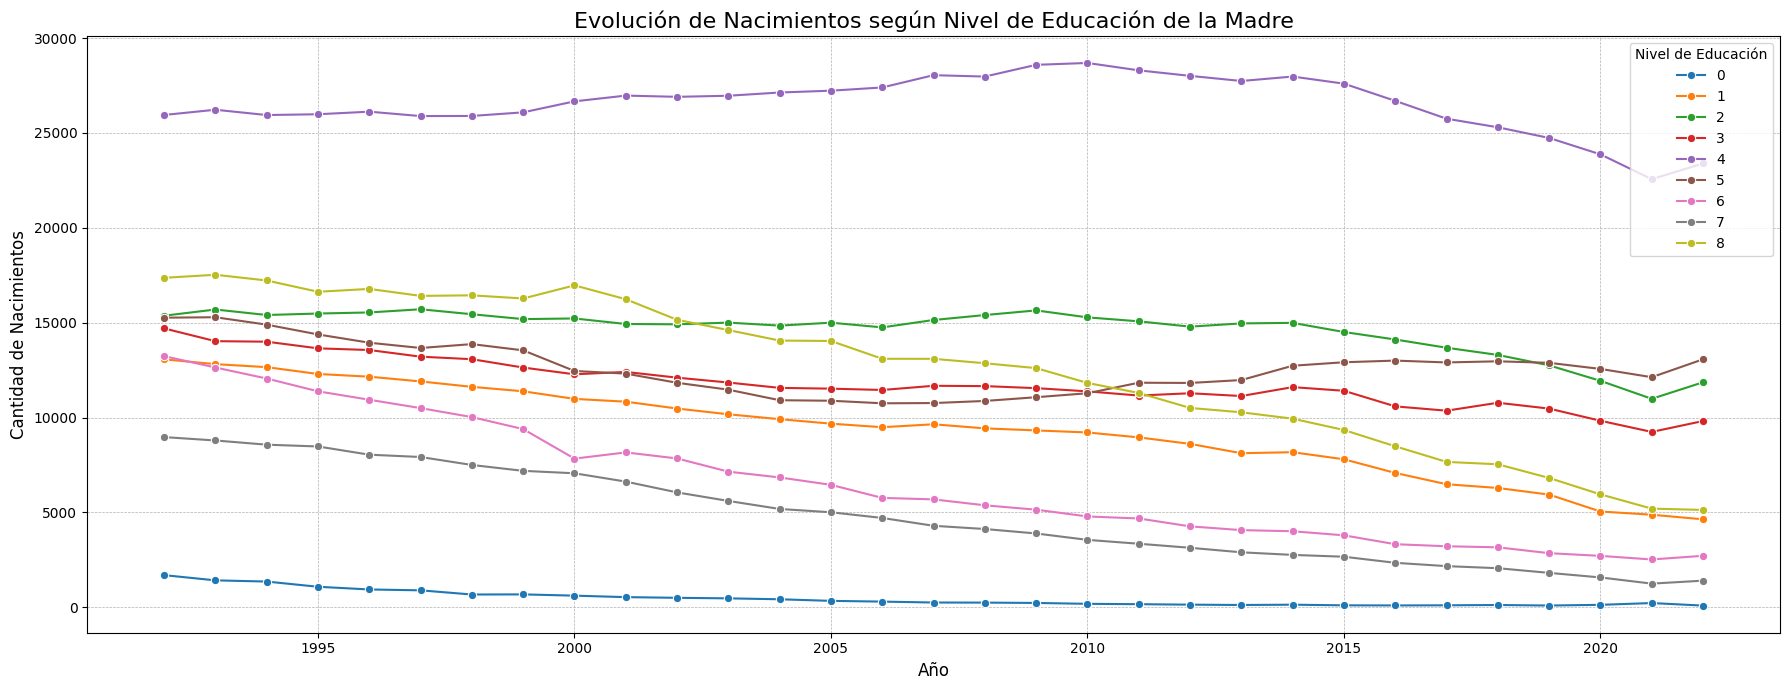

In [97]:
plt.figure(figsize=(18, 7))

sns.lineplot(
    data = nac_por_eduM,
    x= "Anio",
    y= 'Total_nacimientos',
    hue= 'Educacion_M',
    marker= "o",
    palette='tab10'
)
plt.title('Evolución de Nacimientos según Nivel de Educación de la Madre', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Nacimientos', fontsize=12)
plt.legend(title='Nivel de Educación')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig(os.path.join(carpeta_graf, 'nacimientos segun educacion madre.png'), dpi=300, bbox_inches='tight')
plt.show()

In [78]:
df_tendencia = df_nac.groupby('Anio').size().reset_index(name='Total_Nacimientos')

df_train = df_tendencia[df_tendencia['Anio'] <= 2017].copy()
df_test = df_tendencia[df_tendencia['Anio'] > 2017].copy()

anio_base = df_tendencia['Anio'].min()
X_train = (df_train['Anio'] - anio_base).values.reshape(-1, 1)
y_train = df_train['Total_Nacimientos'].values

poly3 = PolynomialFeatures(degree=3)
X_train_poly = poly3.fit_transform(X_train)

modelo_g3 = LinearRegression()
modelo_g3.fit(X_train_poly, y_train)

anios_proyeccion = np.arange(1992, 2026)
X_proy = (anios_proyeccion - anio_base).reshape(-1, 1)
X_proy_poly = poly3.transform(X_proy)

predicciones = modelo_g3.predict(X_proy_poly)

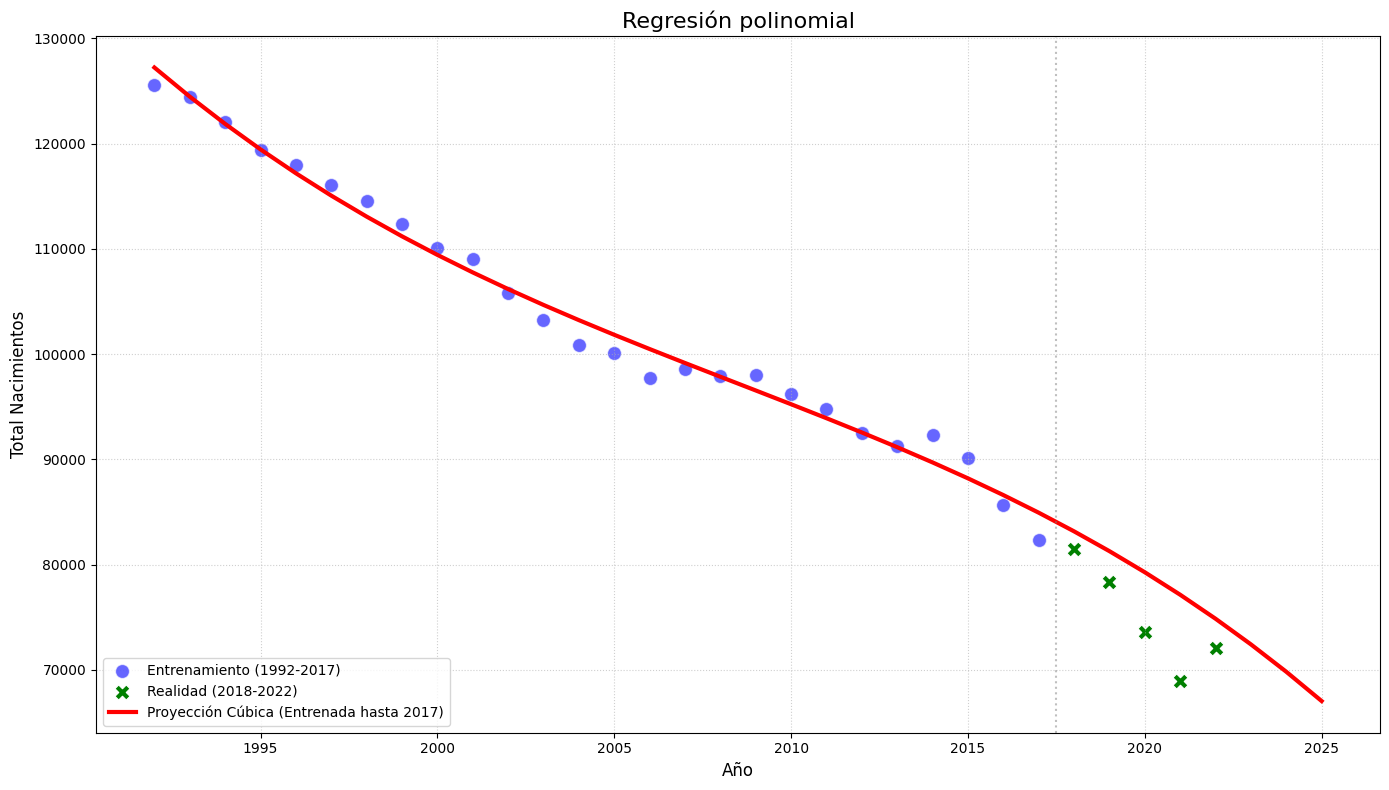

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_train, x='Anio', y='Total_Nacimientos', 
                color='blue', s=100, label='Entrenamiento (1992-2017)', alpha=0.6)

sns.scatterplot(data=df_test, x='Anio', y='Total_Nacimientos', 
                color='green', s=120, marker='X', label='Realidad (2018-2022)', alpha=1.0)

plt.plot(anios_proyeccion, predicciones, color='red', linewidth=3, 
         label='Proyección Cúbica (Entrenada hasta 2017)')

plt.axvline(x=2017.5, color='gray', linestyle=':', alpha=0.5)

plt.title('Regresión polinomial', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total Nacimientos', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(carpeta_graf, 'Regresión polinomial.png'), dpi=300, bbox_inches='tight')
plt.show()

In [81]:
X_test = (df_test['Anio'] - anio_base).values.reshape(-1, 1)
y_test_pred = modelo_g3.predict(poly3.transform(X_test))
mae = mean_absolute_error(df_test['Total_Nacimientos'], y_test_pred)

ultimo_anio = int(df_test['Anio'].max())
real = df_test.iloc[-1]['Total_Nacimientos']
pred = y_test_pred[-1]
error = real - pred

print(f"---Resultados---")
print(f"Error Promedio 2018-2022: {mae:.0f} nacimientos")
print(f"En {ultimo_anio}: Real ({real}) vs Predicción ({pred:.0f})")
print(f"Diferencia: {error:.0f}")

---Resultados---
Error Promedio 2018-2022: 4250 nacimientos
En 2022: Real (72094) vs Predicción (74865)
Diferencia: -2771


# Data RSH 2016-2025
Los datos utilizados para este análisis provienen del portal de datos abiertos del ministerio de desarrollo social y familia de Chile ( https://bidat.gob.cl ). Específicamente se utilizó el conjunto de datos “Personas presentes en el RSH según tramo CSE” (calificación socioeconómica), el cual nos da un conteo de personas a nivel de unidad vecinal, comuna, región y país para cada uno de los tramos de vulnerabilidad del registro social de hogares. La base de datos describe la distribución de la población en siete tramos porcentuales, yendo en descendencia respecto a la vulnerabilidad; (0-40% , 41-50% , 51-60% , 61-70%, 71-80% , 81-90% y 91-100%).
El conjunto de datos completos no estaba disponible en un solo archivo, el procedimiento consistió en la descarga manual de 47 archivos CSV individuales desde el portal del ministerio, para los años 2016 a 2022 eran datos semestrales y desde el 2023 hasta septiembre de 2025 datos mensuales. Entre estos archivos se detectaron dos tipos de archivos en donde algunas estaban codificados en latin1 los cuales contenían dos filas de títulos y una fila de encabezados (nombre de columnas) en la línea tres y los archivos más nuevos estaban codificados en utf-8-sig, los cuales contenían dos filas de meta datos pero no tenían una fila de encabezados por lo tanto los datos comenzaban en la línea tres también había un archivo el cual contenía una columna número 37 la cual estaba completamente vacía ir a producto de un punto; extra al final de cada línea (archivo: “ind_7_87_202306.csv”). La unificación de todos estos archivos se realizó mediante un script de Python utilizando las librerías pandas y Glove mediante un bucle try except para aplicar la distinta lectura dependiendo del tipo de archivo.
Se aplicaron transformaciones para limpiar estos archivos Tales como la estandarización de nombres , estandarización de fechas, imputación de datos censurados puesto que los conteos a nivel de unidad vecinal contenían un valor: “Valores entre 1 y 9”,  los cuales se convirtió a valor nulo y posteriormente con el número 5 que representa el promedio estadístico de dicho rango y los valores nulos encontrados a nivel de comunas se rellenaron con 0.

In [3]:
df_2017 = pd.read_csv(path_censo2017)

In [4]:
df_2017

,REGION,PROVINCIA,COMUNA,AREA,ZC_LOC,ID_ZONA_LOC,número de persona,sexo,edad,"residencia habitual, comuna","residencia habitual, pais","residencia hace 5 años, comuna","residencia hace 5 años, pais",asiste actualmente a educacion formal,curso o año mas alto aprobado,nivel de curso mas alto aprobado,completo el curso,total hijos nacidos vivos,total hijos actualmente vivos,anos en el curso
0,15,152,15202,2,6,13225,1,1,73,98,998,15101,998,2,4,6,2,98,98,4
1,15,152,15202,2,6,13225,1,1,78,98,998,98,998,3,98,98,98,98,98,0
2,15,152,15202,2,6,13225,2,2,78,98,998,98,998,3,98,98,98,1,1,0
3,15,152,15202,2,6,13225,3,2,52,98,998,98,998,1,2,5,2,2,1,2
4,15,152,15202,2,6,13225,4,1,44,98,998,98,998,1,3,5,2,98,98,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17573998,1,11,1101,1,999,12486,1,1,74,98,998,98,998,2,3,5,2,98,98,3
17573999,1,11,1101,1,999,12486,1,1,36,98,998,98,998,2,4,7,1,98,98,12
17574000,1,11,1101,1,999,12486,1,2,51,98,998,98,998,2,4,12,1,3,3,16
17574001,1,11,1101,1,999,12486,2,2,19,98,998,98,998,1,1,12,2,0,98,13


In [28]:
df_rsh = pd.read_csv(path_rsh_pob)

C:\Users\boris\AppData\Local\Temp\ipykernel_9708\1636234258.py:1: DtypeWarning: Columns (10,14,18,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rsh = pd.read_csv(path_rsh_pob)


C:\Users\boris\AppData\Local\Temp\ipykernel_9708\2249696036.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


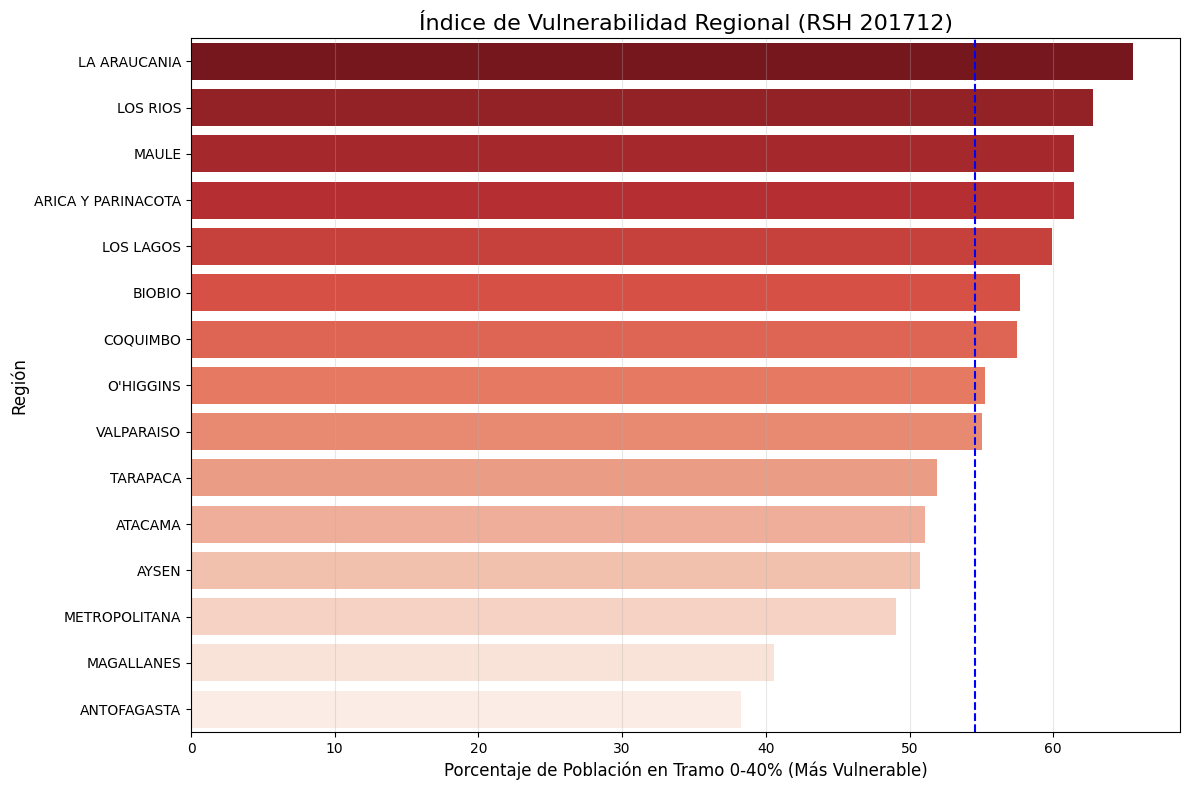

In [99]:
df_rsh['periodo_str'] = df_rsh['periodo'].astype(str)
df_rsh_2017_raw = df_rsh[df_rsh['periodo_str'].str.startswith('2017')]

periodo_foto = df_rsh_2017_raw['periodo'].max()
df_rsh_2017 = df_rsh_2017_raw[df_rsh_2017_raw['periodo'] == periodo_foto].groupby('region').last().reset_index()

df_rsh_2017['Porcentaje_Vulnerabilidad'] = (df_rsh_2017['n_personas_0_40_region'] / df_rsh_2017['total_region']) * 100

regiones_map = {
    1: 'TARAPACA', 2: 'ANTOFAGASTA', 3: 'ATACAMA', 4: 'COQUIMBO', 5: 'VALPARAISO',
    6: "O'HIGGINS", 7: 'MAULE', 8: 'BIOBIO', 9: 'LA ARAUCANIA', 10: 'LOS LAGOS',
    11: 'AYSEN', 12: 'MAGALLANES', 13: 'METROPOLITANA', 14: 'LOS RIOS',
    15: 'ARICA Y PARINACOTA', 16: 'NUBLE'
}
df_rsh_2017['Region_Nombre'] = df_rsh_2017['region'].map(regiones_map)

df_rsh_2017 = df_rsh_2017.sort_values('Porcentaje_Vulnerabilidad', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_rsh_2017,
    x='Porcentaje_Vulnerabilidad',
    y='Region_Nombre',
    palette='Reds_r')

promedio_nacional = df_rsh_2017['Porcentaje_Vulnerabilidad'].mean()
plt.axvline(x=promedio_nacional, color='blue', linestyle='--', label=f'Promedio Nacional: {promedio_nacional:.1f}%')

plt.title(f'Índice de Vulnerabilidad Regional (RSH {periodo_foto})', fontsize=16)
plt.xlabel('Porcentaje de Población en Tramo 0-40% (Más Vulnerable)', fontsize=12)
plt.ylabel('Región', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(carpeta_graf, 'Vulnerabilidad regional.png'), dpi=300, bbox_inches='tight')
plt.show()